# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 12.10.2024

Мягкий дедлайн: 23:59MSK 27.10.2024

Жесткий дедлайн: 23:59MSK 31.10.2024

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: xx.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [1302]:
# !pip install folium

In [5]:
import folium

m = folium.Map(location=(50.97178, 9.79418), zoom_start=15)

m

/Users/ruslanf/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Если вы всё сделали правильно, то выше должна открыться карта

### 📌 **Памятка по дз2**

Обрабатывать данные можно любым способом (`polars`, `pandas`, `pyspark`, ...), который вам нравится и запускается в ноутбуке, и любой библиотекой для визуализации (`matplotlib`, `seaborn`, `plotly`, ...). Пользуйтесь на здоровье, но!

> Учтите, что `polars` всё ещё молодой и не все библиотеки его поддерживают. `sklearn` во многом уже работает, но на всякий случай не стесняйтесь пользоваться методами `pl.DataFrame.to_pandas()` или `pl.DataFrame.to_numpy()`    

> Впрочем, `pandas` тоже не лишён проблем. `sklearn` принимает `pd.DataFrame` почти везде, проблемы очень редки, но если вдруг возникнет какая-то беда с шейпами, или ещё какой-нибудь казус, а вы уверены, что всё правильно, пользуйтесь `pd.DataFrame.to_numpy()`. Это не всегда решает проблему, но часто помогает понять, что на самом деле не так. При желании можно передавать и `Iterable`, и sparse-матрицы

> Графики должны быть понятные, читаемые и пр. Консультируйтесь с памяткой из дз1 в задании на график

> Для воспроизводимости результатов не забывайте пользоваться `np.random.seed(...)`, при необходимости чистите мусор `gc.collect()`, лучше в каждой ячейке

> Все результаты должны быть получены в ноутбуке. На каждый **Вопрос** долен быть дан **Ответ** (письменно (в Markdown например) или кодом)

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
# import ...  # your favorite data package
# import ...  # your favorite visualization package

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [7]:
data_train = pd.read_csv('./nyc-taxi-trip-duration/train.csv')
X_test = pd.read_csv('./nyc-taxi-trip-duration/test.csv')
y_test = pd.read_csv('./nyc-taxi-trip-duration/sample_submission.csv').drop('id', axis=1)


Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [8]:
data_train = data_train.drop('dropoff_datetime', axis=1)
data_train['pickup_datetime'] = pd.to_datetime(data_train['pickup_datetime'])
X_test['pickup_datetime'] = pd.to_datetime(X_test['pickup_datetime'])

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

In [9]:
data_train.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [10]:
X_test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [11]:
X_train, y_train = data_train.drop('trip_duration', axis=1), data_train['trip_duration']

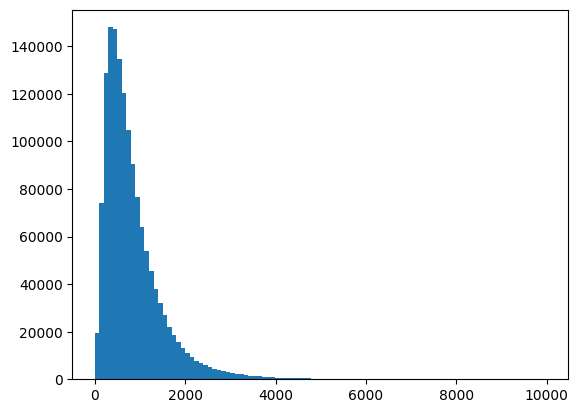

In [12]:
plt.hist(y_train[y_train<10000], bins=100)
plt.show()

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**: ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

In [13]:
y_train = np.log1p(y_train)

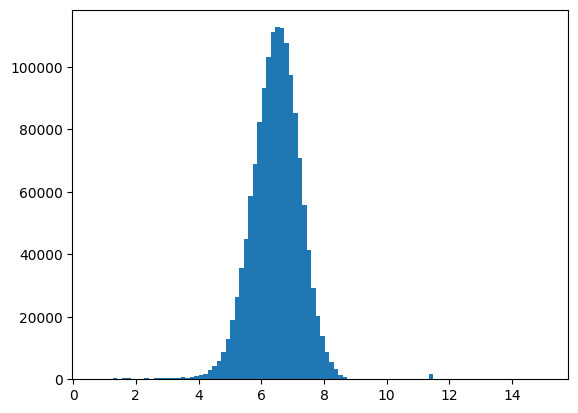

In [14]:
plt.hist(y_train[y_train<10000], bins=100)
plt.show()

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [15]:
def rmsle(log1p_y_true, log1p_y_pred):
    return np.sqrt(np.mean((log1p_y_true-log1p_y_pred)**2))

rmsle_best_const = rmsle(y_train, np.mean(y_train))
print(rmsle_best_const)
assert np.allclose(rmsle_best_const, 0.79575, 1e-4)

0.7957592365411509


## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году:

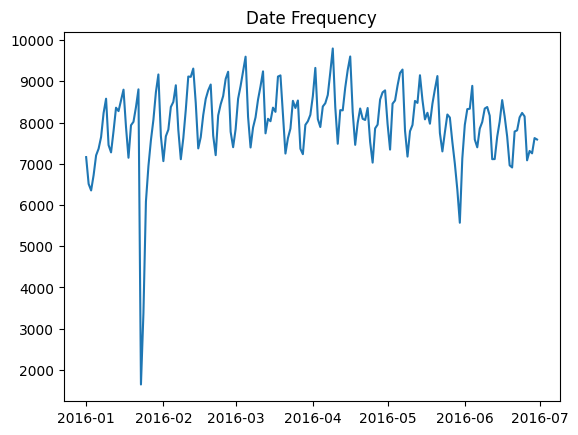

In [16]:
date_counts = X_train['pickup_datetime'].dt.date.value_counts().sort_index()
plt.plot(date_counts.index, date_counts.values)
plt.title('Date Frequency')
plt.show()

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках:

In [17]:
date_counts.sort_values()[:3].index

Index([2016-01-23, 2016-01-24, 2016-05-30], dtype='object', name='pickup_datetime')

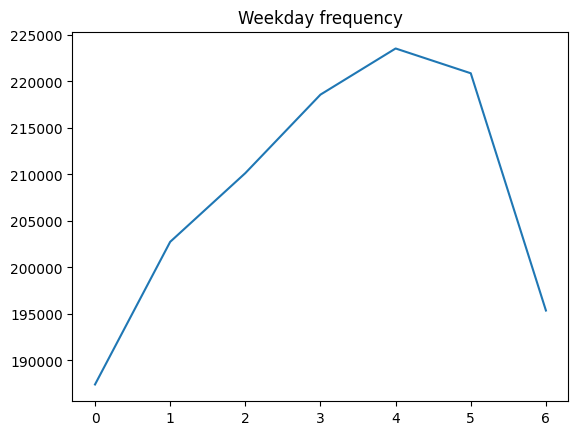

In [18]:
weekday_counts = X_train['pickup_datetime'].dt.weekday.value_counts().sort_index()
plt.plot(weekday_counts.index, weekday_counts.values)
plt.xticks(range(7))
plt.title('Weekday frequency')
plt.show()

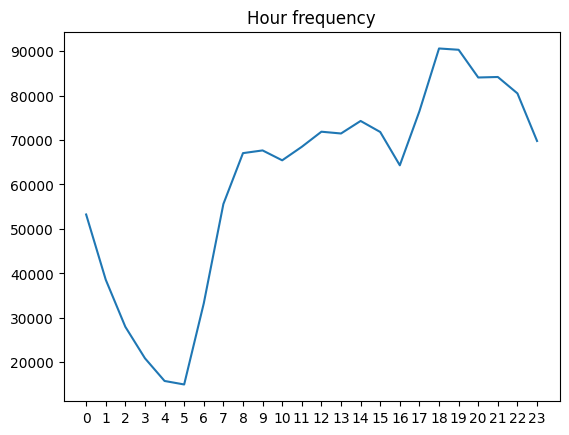

In [19]:
hour_counts = X_train['pickup_datetime'].dt.hour.value_counts().sort_index()
plt.plot(hour_counts.index, hour_counts.values)
plt.xticks(range(24))
plt.title('Hour frequency')
plt.show()

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, поищите, как это делается). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

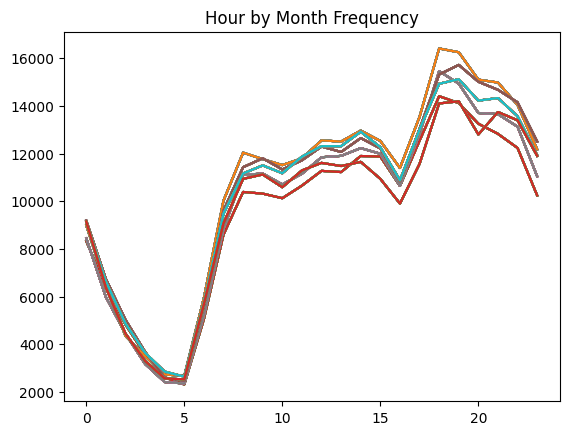

In [20]:
month_hour_group = X_train['pickup_datetime'].groupby([X_train['pickup_datetime'].dt.month, X_train['pickup_datetime'].dt.hour]).size()

for month_i in month_hour_group.index.get_level_values(0):
    plt.plot(month_hour_group.loc[month_i].index, month_hour_group.loc[month_i].values)

plt.title('Hour by Month Frequency')
plt.show()

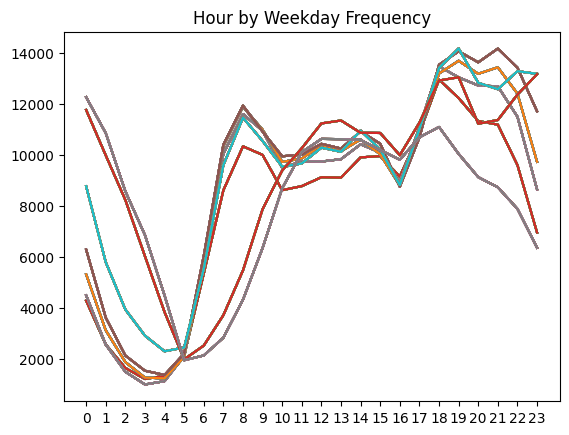

In [21]:
weekday_hour_group = X_train['pickup_datetime'].groupby([X_train['pickup_datetime'].dt.weekday, X_train['pickup_datetime'].dt.hour]).size()

for weekday in weekday_hour_group.index.get_level_values(0):
    plt.plot(weekday_hour_group.loc[weekday].index, weekday_hour_group.loc[weekday].values)

plt.xticks(range(24))
plt.title('Hour by Weekday Frequency')
plt.show()

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3 (используйте `train_test_split` из `sklearn`). По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=.7, shuffle=False)
X_temp = pd.concat((X_train, y_train), axis=1)

In [23]:
X_temp.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,6.122493
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,6.498282
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,7.661527
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,6.063785
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,6.077642


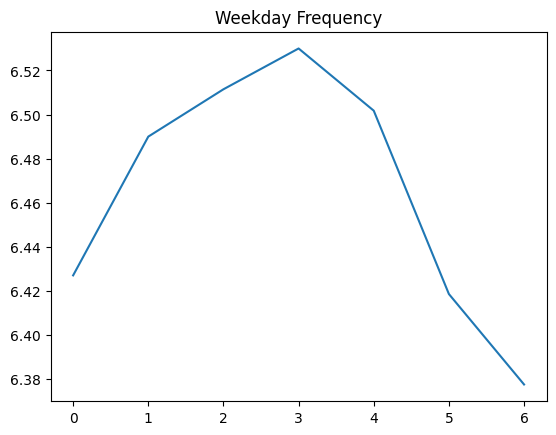

In [24]:
log_trip_duration_by_weekday = X_temp.groupby(X_temp['pickup_datetime'].dt.weekday)['trip_duration'].mean()
plt.plot(log_trip_duration_by_weekday.index, log_trip_duration_by_weekday.values)
plt.title('Weekday Frequency')
plt.show()

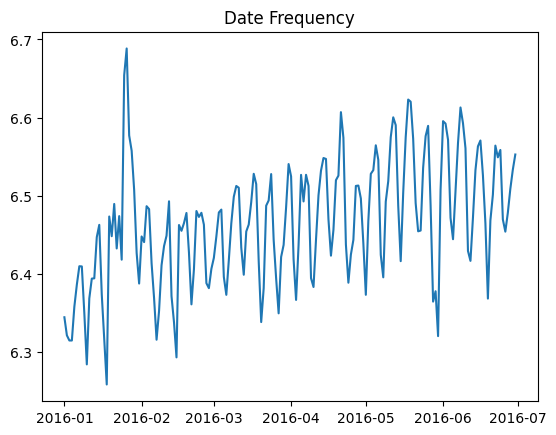

In [25]:
log_trip_duration_by_date = X_temp.groupby(X_temp['pickup_datetime'].dt.date)['trip_duration'].mean()
plt.plot(log_trip_duration_by_date.index, log_trip_duration_by_date.values)
plt.title('Date Frequency')
plt.show()

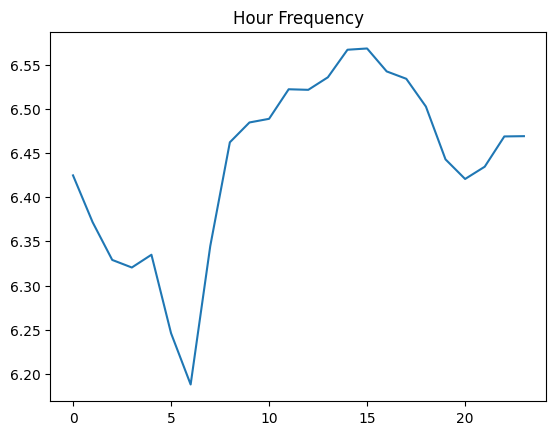

In [26]:
log_trip_duration_by_hour = X_temp.groupby(X_temp['pickup_datetime'].dt.hour)['trip_duration'].mean()
plt.plot(log_trip_duration_by_hour.index, log_trip_duration_by_hour.values)
plt.title('Hour Frequency')
plt.show()

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [27]:
import datetime

X_temp = pd.concat([X_train, X_val], axis=0)
X_temp['weekday'] = X_temp['pickup_datetime'].dt.weekday
X_temp['month'] = X_temp['pickup_datetime'].dt.month
X_temp['hour'] = X_temp['pickup_datetime'].dt.hour
X_temp['dayofyear'] = X_temp['pickup_datetime'].dt.dayofyear

blizzard_start = datetime.date(2016, 1, 22)
blizzard_end = datetime.date(2016, 1, 24)
X_temp['anomaly_blizzard'] = X_temp['pickup_datetime'].dt.date.between(blizzard_start, blizzard_end, inclusive='both')
X_temp['anomaly_summer'] = X_temp['pickup_datetime'].dt.date == datetime.date(2016, 5, 30)

X_train, X_val = X_temp.loc[X_train.index], X_temp.loc[X_val.index]

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков _стоит рассматривать в этой задаче_   как категориальные, а какие - как численные? Почему?

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [28]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder

leave_as_is_features = ['month', 'weekday', 'hour', 'dayofyear', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
scaler_features = []
ohe_features = ['vendor_id', 'store_and_fwd_flag', 'anomaly_blizzard', 'anomaly_summer', 'passenger_count']

scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False, min_frequency=50)

X_train_preprocessed = X_train.copy().drop(['id', 'pickup_datetime'], axis=1)
X_val_preprocessed = X_val.copy().drop(['id', 'pickup_datetime'], axis=1)

# X_train_preprocessed[scaler_features] = scaler.fit_transform(X_train[scaler_features])
# X_val_preprocessed[scaler_features] = scaler.transform(X_val[scaler_features])

ohe_new_feature_names = ohe.fit(X_train[ohe_features]).get_feature_names_out()
X_train_preprocessed = pd.concat([
    X_train_preprocessed,
    pd.DataFrame(ohe.transform(X_train[ohe_features]), index=X_train_preprocessed.index, columns=ohe_new_feature_names).astype(int)
], axis=1).drop(ohe_features, axis=1)
X_val_preprocessed = pd.concat([
    X_val_preprocessed,
    pd.DataFrame(ohe.transform(X_val[ohe_features]), index=X_val_preprocessed.index, columns=ohe_new_feature_names).astype(int)
], axis=1).drop(ohe_features, axis=1)

In [29]:
X_train_preprocessed.head(5)

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,weekday,month,hour,dayofyear,vendor_id_2,store_and_fwd_flag_Y,anomaly_blizzard_True,anomaly_summer_True,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_infrequent_sklearn
0,-73.982155,40.767937,-73.964630,40.765602,0,3,17,74,1,0,0,0,0,0,0,0,0,0
1,-73.980415,40.738564,-73.999481,40.731152,6,6,0,164,0,0,0,0,0,0,0,0,0,0
2,-73.979027,40.763939,-74.005333,40.710087,1,1,11,19,1,0,0,0,0,0,0,0,0,0
3,-74.010040,40.719971,-74.012268,40.706718,2,4,19,97,1,0,0,0,0,0,0,0,0,0
4,-73.973053,40.793209,-73.972923,40.782520,5,3,13,86,1,0,0,0,0,0,0,0,0,0


In [30]:
from sklearn.metrics import mean_squared_error

ridge = Ridge().fit(X_train_preprocessed, y_train)
predictions_test = ridge.predict(X_val_preprocessed)
rmsle = np.sqrt(mean_squared_error(y_val, predictions_test))
print(rmsle)

0.8540348205904632


## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [31]:
from typing import Iterable

def show_circles_on_map(
    latitude_values: Iterable[float],
    longitude_values: Iterable[float],
    color: str = "blue",
) -> folium.Map:
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    Works best on samples of size < 10k, too costly otherwise

    latitude_values: sample latitude values of a dataframe
    longitude_column: sample longitude values of a dataframe
    color: the color of circles to be drawn
    """

    location = (np.mean(latitude_values), np.mean(longitude_values))
    m = folium.Map(location=location)

    for lat, lon in zip(latitude_values, longitude_values):
        folium.Circle(
            radius=100,
            location=(lat, lon),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    min_lat, max_lat = 40.4, 41.0   #NYC
    min_lon, max_lon = -74.3, -73.5
    lat_interval = .05
    lon_interval = .05
    grid_lines = []

    for lat in np.arange(min_lat, max_lat+lat_interval, lat_interval):
        points = ((lat, min_lon), (lat, max_lon))
        grid_lines.append(folium.PolyLine(locations=points, color='gray', weight=1, opacity=0.7))

    for lon in np.arange(min_lon, max_lon+lon_interval, lon_interval):
        points = ((min_lat, lon), (max_lat, lon))
        grid_lines.append(folium.PolyLine(locations=points, color='gray', weight=1, opacity=0.7))

    for line in grid_lines:
        line.add_to(m)

    return m

Напишите функция, которая вернет значения колонок `pickup_latitude`, `pickup_longitude` на каком-нибудь разумном кусочке датафрейма, например, `df.sample(1000)` и покажите на карте, используя `show_circles_on_map`

In [32]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
your_lat_values = X_train.sample(1000)['pickup_latitude']
your_lon_values = X_train.sample(1000)['pickup_longitude']

show_circles_on_map(your_lat_values, your_lon_values, color="midnightblue")

**Вопрос**: Какие пункты (или скопления точек, в количестве 2-3), по вашему мнению, выделяются на карте от основной массы и могут быть полезны для нашей задачи? Почему вы их выбрали? В чём особенность этих скоплений точек для нашей задачи?

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [33]:
from haversine import haversine_vector

X_train_preprocessed['distance'] = haversine_vector(
    list(zip(X_train['pickup_latitude'], X_train['pickup_longitude'])),
    list(zip(X_train['dropoff_latitude'], X_train['dropoff_longitude'])),
    unit='km'
)

X_val_preprocessed['distance'] = haversine_vector(
    list(zip(X_val['pickup_latitude'], X_val['pickup_longitude'])),
    list(zip(X_val['dropoff_latitude'],X_val['dropoff_longitude'])),
    unit='km'
)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку `log_haversine`:

In [34]:
X_train_preprocessed['log_distance'] = np.log1p(X_train_preprocessed['distance'])
X_val_preprocessed['log_distance'] = np.log1p(X_val_preprocessed['distance'])

Посчитайте корреляцию и убедитесь, что логарифм расстояния лучше отражает таргет, чем просто расстояние:

In [35]:
distance_correlation = X_train_preprocessed['distance'].corr(y_train)
log_distance_correlation = X_train_preprocessed['log_distance'].corr(y_train)

print(f"Корреляция таргета с расстоянием: {distance_correlation:.4f}")
print(f"Корреляция таргета с log(расстоянием): {log_distance_correlation:.4f}")

Корреляция таргета с расстоянием: 0.5608
Корреляция таргета с log(расстоянием): 0.7498


**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

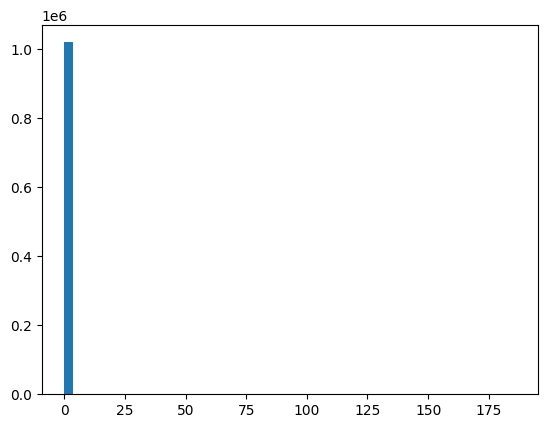

In [36]:
plt.hist(X_train_preprocessed['distance'] / y_train, bins=50)
plt.show()

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

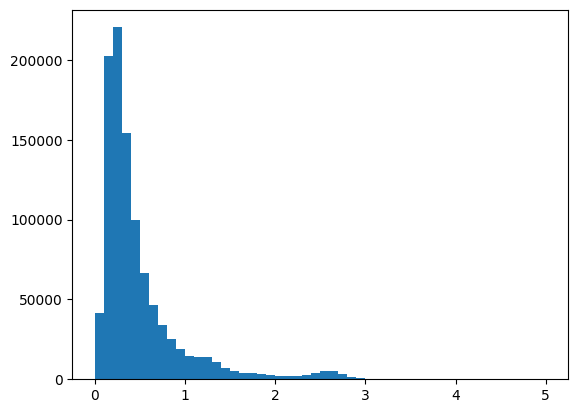

In [37]:
plt.hist(X_train_preprocessed['distance'] / y_train, bins=50, range=(0,5))
plt.show()

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте Heatmap-график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

In [38]:
X_temp = X_train_preprocessed.copy()
X_temp['velocity'] = X_train_preprocessed['distance'] / y_train

In [39]:
velocity_matrix = X_temp.groupby(['weekday', 'hour'])['velocity'].median().unstack(level='weekday')\
    .sort_index(axis=0).sort_index(axis=1).T
velocity_matrix

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
weekday,,,,,,,,,,,,,,,,,,,,,
0,0.485067,0.470972,0.488575,0.499413,0.613952,0.493489,0.377372,0.332986,0.297822,0.283151,...,0.297364,0.293901,0.295819,0.300303,0.304647,0.317446,0.365325,0.386500,0.402590,0.440075
1,0.455398,0.480297,0.460484,0.516235,0.577919,0.427841,0.363460,0.313914,0.277199,0.270949,...,0.281080,0.275532,0.280285,0.293097,0.291681,0.310074,0.350261,0.379083,0.407704,0.427608
2,0.452047,0.449912,0.463058,0.499470,0.564899,0.432411,0.355468,0.322068,0.282642,0.269851,...,0.276640,0.275419,0.289920,0.295911,0.294298,0.303637,0.347085,0.377484,0.393469,0.423495
3,0.437476,0.458134,0.491259,0.510891,0.546043,0.457949,0.366515,0.319805,0.283352,0.278212,...,0.282339,0.280445,0.288847,0.295333,0.297178,0.311910,0.343298,0.372241,0.388147,0.410699
4,0.431354,0.430286,0.427140,0.460551,0.541599,0.489602,0.371220,0.326021,0.289300,0.275898,...,0.296265,0.294216,0.300965,0.298473,0.297636,0.304396,0.324071,0.341295,0.357868,0.380387
5,0.384790,0.402037,0.402355,0.433640,0.485367,0.573060,0.453096,0.387276,0.343034,0.325411,...,0.305166,0.312945,0.317475,0.324011,0.307481,0.308541,0.314052,0.331971,0.342200,0.368727
6,0.383158,0.392152,0.412049,0.429119,0.456083,0.536944,0.531868,0.407922,0.347725,0.340853,...,0.333884,0.329691,0.342653,0.339220,0.333735,0.335522,0.359100,0.376428,0.404156,0.441799


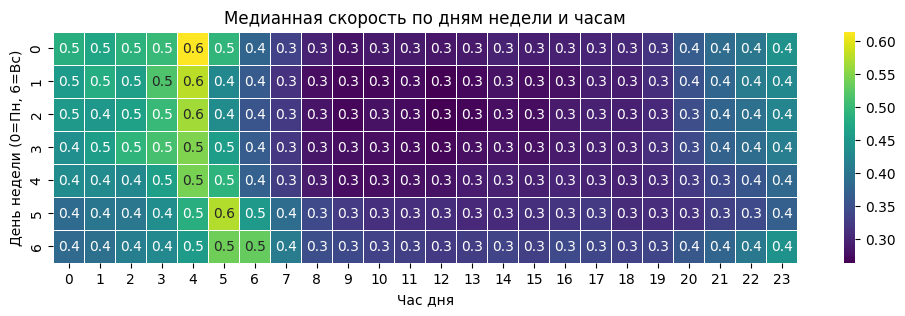

In [44]:
import seaborn as sns

velocity_matrix = X_temp.groupby(['weekday', 'hour'])['velocity'].median().unstack(level='weekday')\
    .sort_index(axis=0).sort_index(axis=1).T

plt.figure(figsize=(12,3))
sns.heatmap(
    velocity_matrix, 
    cmap='viridis',   # Выбираем цветовую схему (например, 'viridis', 'YlGnBu' [2], 'magma' [5])
    annot=True,       # Показать значения в ячейках (если их не слишком много)
    fmt=".1f",        # Формат для значений (1 знак после запятой)
    linewidths=.5     # Линии между ячейками
)
# plt.imshow(velocity_matrix)

plt.title('Медианная скорость по дням недели и часам')
plt.xlabel('Час дня')
plt.ylabel('День недели (0=Пн, 6=Вс)')
plt.show()

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

In [1404]:
# прокси к таргету

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [1405]:
median_velocities = velocity_matrix.values
jam_threshold = np.quantile(median_velocities, .25)
free_threshold = np.quantile(median_velocities, .75)

period_map = X_temp.groupby(['weekday', 'hour'])['velocity'].median().reset_index()
period_map['is_jam_period'] = period_map['velocity'] <= jam_threshold
period_map['is_free_period'] = period_map['velocity'] >= free_threshold
period_map = period_map.drop('velocity', axis=1)

X_train_preprocessed = X_train_preprocessed.merge(period_map, on=['weekday', 'hour'], how='left')
X_val_preprocessed = X_val_preprocessed.merge(period_map, on=['weekday', 'hour'], how='left')

X_train_preprocessed[['is_jam_period', 'is_free_period']] = X_train_preprocessed[['is_jam_period', 'is_free_period']].fillna(False)
X_val_preprocessed[['is_jam_period', 'is_free_period']] = X_val_preprocessed[['is_jam_period', 'is_free_period']].fillna(False)

In [1406]:
X_train_preprocessed.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,weekday,month,hour,dayofyear,vendor_id_2,store_and_fwd_flag_Y,...,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_infrequent_sklearn,distance,log_distance,is_jam_period,is_free_period
0,-73.982155,40.767937,-73.964630,40.765602,0,3,17,74,1,0,...,0,0,0,0,0,0,1.498523,0.915700,False,False
1,-73.980415,40.738564,-73.999481,40.731152,6,6,0,164,0,0,...,0,0,0,0,0,0,1.805510,1.031585,False,False
2,-73.979027,40.763939,-74.005333,40.710087,1,1,11,19,1,0,...,0,0,0,0,0,0,6.385107,1.999465,True,False
3,-74.010040,40.719971,-74.012268,40.706718,2,4,19,97,1,0,...,0,0,0,0,0,0,1.485500,0.910474,False,False
4,-73.973053,40.793209,-73.972923,40.782520,5,3,13,86,1,0,...,0,0,0,0,0,0,1.188590,0.783258,False,False


**Задание 8 (0.25 балла)**. Для каждого из замеченных вами выше 2-3 пунктов добавьте в выборку по два признака:
- началась ли поездка в этом пункте
- закончилась ли поездка в этом пункте

Как вы думаете, почему эти признаки могут быть полезны?

In [1407]:
X_train.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,weekday,month,hour,dayofyear,anomaly_blizzard,anomaly_summer
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,0,3,17,74,False,False
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,6,6,0,164,False,False
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,1,1,11,19,False,False
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,2,4,19,97,False,False
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,5,3,13,86,False,False


In [1408]:
X_val['pickup_latitude']

1021050    40.705730
1021051    40.738808
1021052    40.788578
1021053    40.749969
1021054    40.793392
             ...    
1458639    40.745522
1458640    40.747379
1458641    40.768799
1458642    40.749062
1458643    40.781750
Name: pickup_latitude, Length: 437594, dtype: float64

In [1409]:
def is_in_box(lat, lon, lat_min, lon_min, lat_max, lon_max):
    return (lat >= lat_min) & (lat <= lat_max) & (lon >= lon_min) & (lon <= lon_max)

#train
X_train_preprocessed['start_jfk'] = is_in_box(X_train_preprocessed['pickup_latitude'], X_train_preprocessed['pickup_longitude'], 40.65, -73.81, 40.80, -73.75)
X_train_preprocessed['end_jfk'] = is_in_box(X_train_preprocessed['dropoff_latitude'], X_train_preprocessed['dropoff_longitude'], 40.65, -73.81, 40.80, -73.75)

X_train_preprocessed['start_lga'] = is_in_box(X_train_preprocessed['pickup_latitude'], X_train_preprocessed['pickup_longitude'], 40.65, -73.92, 40.80, -73.825)
X_train_preprocessed['end_lga'] = is_in_box(X_train_preprocessed['dropoff_latitude'], X_train_preprocessed['dropoff_longitude'], 40.65, -73.92, 40.80, -73.825)

X_train_preprocessed['start_manhattan'] = is_in_box(X_train_preprocessed['pickup_latitude'], X_train_preprocessed['pickup_longitude'], 40.60, -74.05, 40.90, -73.925)
X_train_preprocessed['end_manhattan'] = is_in_box(X_train_preprocessed['dropoff_latitude'], X_train_preprocessed['dropoff_longitude'], 40.60, -74.05, 40.90, -73.925)

#validation
X_val_preprocessed['start_jfk'] = is_in_box(X_val_preprocessed['pickup_latitude'], X_val_preprocessed['pickup_longitude'], 40.65, -73.81, 40.80, -73.75)
X_val_preprocessed['end_jfk'] = is_in_box(X_val_preprocessed['dropoff_latitude'], X_val_preprocessed['dropoff_longitude'], 40.65, -73.81, 40.80, -73.75)

X_val_preprocessed['start_lga'] = is_in_box(X_val_preprocessed['pickup_latitude'], X_val_preprocessed['pickup_longitude'], 40.65, -73.92, 40.80, -73.825)
X_val_preprocessed['end_lga'] = is_in_box(X_val_preprocessed['dropoff_latitude'], X_val_preprocessed['dropoff_longitude'], 40.65, -73.92, 40.80, -73.825)

X_val_preprocessed['start_manhattan'] = is_in_box(X_val_preprocessed['pickup_latitude'], X_val_preprocessed['pickup_longitude'], 40.60, -74.05, 40.90, -73.925)
X_val_preprocessed['end_manhattan'] = is_in_box(X_val_preprocessed['dropoff_latitude'], X_val_preprocessed['dropoff_longitude'], 40.60, -74.05, 40.90, -73.925)

In [1410]:
X_train_preprocessed

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,weekday,month,hour,dayofyear,vendor_id_2,store_and_fwd_flag_Y,...,distance,log_distance,is_jam_period,is_free_period,start_jfk,end_jfk,start_lga,end_lga,start_manhattan,end_manhattan
0,-73.982155,40.767937,-73.964630,40.765602,0,3,17,74,1,0,...,1.498523,0.915700,False,False,False,False,False,False,True,True
1,-73.980415,40.738564,-73.999481,40.731152,6,6,0,164,0,0,...,1.805510,1.031585,False,False,False,False,False,False,True,True
2,-73.979027,40.763939,-74.005333,40.710087,1,1,11,19,1,0,...,6.385107,1.999465,True,False,False,False,False,False,True,True
3,-74.010040,40.719971,-74.012268,40.706718,2,4,19,97,1,0,...,1.485500,0.910474,False,False,False,False,False,False,True,True
4,-73.973053,40.793209,-73.972923,40.782520,5,3,13,86,1,0,...,1.188590,0.783258,False,False,False,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1021045,-73.988510,40.754490,-73.983101,40.781673,2,5,23,125,0,0,...,3.056809,1.400397,False,True,False,False,False,False,True,True
1021046,-73.965134,40.759537,-73.955917,40.773766,6,4,15,94,0,0,...,1.762302,1.016064,False,False,False,False,False,False,True,True
1021047,-73.979874,40.755943,-73.985954,40.750633,5,1,18,16,0,0,...,0.781648,0.577539,False,False,False,False,False,False,True,True
1021048,-73.983711,40.737953,-73.996086,40.744373,0,1,7,11,1,0,...,1.263559,0.816938,False,False,False,False,False,False,True,True


Для каждого из созданных признаков нарисуйте "ящик с усами" (aka boxplot) распределения логарифма времени поездки

<Axes: xlabel='start', ylabel='trip_duration'>

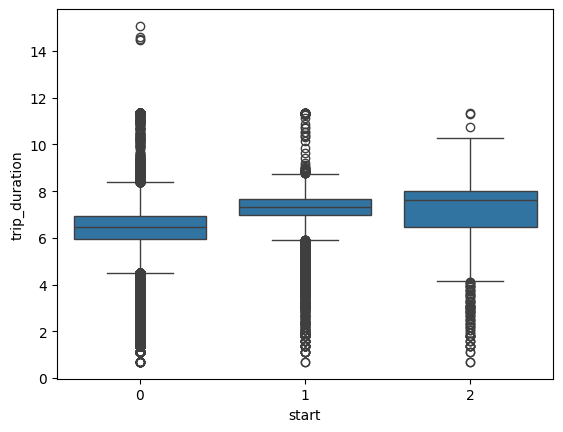

In [1411]:
X_temp = X_train_preprocessed.copy()
X_temp['start'] = np.argmax(pd.concat([X_train_preprocessed['start_manhattan'], X_train_preprocessed['start_lga'], X_train_preprocessed['start_jfk']], axis=1).to_numpy(), axis=1)
X_temp['end'] = np.argmax(pd.concat([X_train_preprocessed['end_manhattan'], X_train_preprocessed['end_lga'], X_train_preprocessed['end_jfk']], axis=1).to_numpy(), axis=1) 

sns.boxplot(pd.concat((X_temp['start'], y_train), axis=1), x="start", y="trip_duration")

<Axes: xlabel='end', ylabel='trip_duration'>

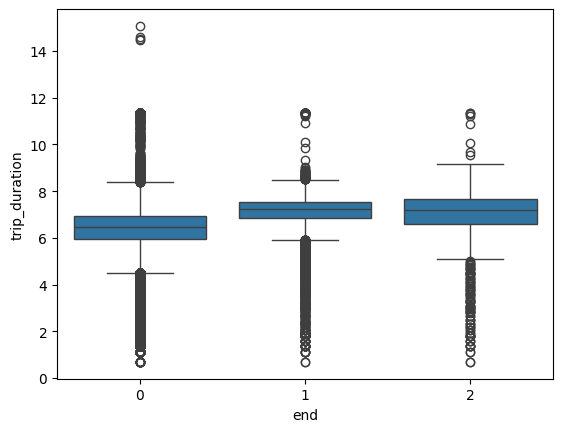

In [1412]:
sns.boxplot(pd.concat((X_temp['end'], y_train), axis=1), x="end", y="trip_duration")

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [1413]:
from sklearn.base import BaseEstimator, TransformerMixin


class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, x_divisions=None, y_divisions=None):
        self.bounding_box = None
        self.x_divisions = x_divisions or 3
        self.y_divisions = y_divisions or 3

    
    def show_map(self):
        location = np.mean(self.bounding_box, axis=0)
        m = folium.Map(location=location)
        
        grid_lines = []

        print(self.y_divisions)
        for lat in np.linspace(self.bounding_box[0][0], self.bounding_box[1][0], self.y_divisions):
            points = ((lat, self.bounding_box[0][1]), (lat, self.bounding_box[1][1]))
            grid_lines.append(folium.PolyLine(locations=points, color='blue', weight=1, opacity=0.7))

        print(self.x_divisions)
        for lon in np.linspace(self.bounding_box[0][1], self.bounding_box[1][1], self.x_divisions):
            points = ((self.bounding_box[0][0], lon), (self.bounding_box[1][0], lon))
            grid_lines.append(folium.PolyLine(locations=points, color='blue', weight=1, opacity=0.7))
    
        for line in grid_lines:
            line.add_to(m)

        return m
        

    def fit(self, X=None, y=None):
        self.bounding_box = [[
            np.min(pd.concat((X.loc[X['start_manhattan'], 'pickup_latitude'], X.loc[X['end_manhattan'], 'dropoff_latitude']), axis=0)),
            np.min(pd.concat((X.loc[X['start_manhattan'], 'pickup_longitude'], X.loc[X['end_manhattan'], 'dropoff_longitude']), axis=0))
        ],[
            np.max(pd.concat((X.loc[X['start_manhattan'], 'pickup_latitude'], X.loc[X['end_manhattan'], 'dropoff_latitude']), axis=0)),
            np.max(pd.concat((X.loc[X['start_manhattan'], 'pickup_longitude'], X.loc[X['end_manhattan'], 'dropoff_longitude']), axis=0))
        ]]
        return self

        
    def transform(self, X, y=None):
        if self.bounding_box == None:
            raise RuntimeError('Perform fitting before transform')
            
        pickup_box_y = np.floor((X['pickup_latitude']-self.bounding_box[0][0]) / (self.bounding_box[1][0]-self.bounding_box[0][0]) * (self.y_divisions))
        pickup_box_x = np.floor((X['pickup_longitude']-self.bounding_box[0][1]) / (self.bounding_box[1][1]-self.bounding_box[0][1]) * (self.x_divisions))

        pickup_box = (pickup_box_y*self.x_divisions + pickup_box_x).astype(int)
        pickup_box.loc[
            (X['pickup_latitude'] < self.bounding_box[0][0]) |
            (X['pickup_latitude'] >= self.bounding_box[1][0]) |
            (X['pickup_longitude'] < self.bounding_box[0][1]) |
            (X['pickup_longitude'] >= self.bounding_box[1][1])
        ] = -1
        
        dropoff_box_y = np.floor((X['dropoff_latitude']-self.bounding_box[0][0]) / (self.bounding_box[1][0]-self.bounding_box[0][0]) * (self.y_divisions))
        dropoff_box_x = np.floor((X['dropoff_longitude']-self.bounding_box[0][1]) / (self.bounding_box[1][1]-self.bounding_box[0][1]) * (self.x_divisions))
        
        dropoff_box = (dropoff_box_y*self.x_divisions + dropoff_box_x).astype(int)
        dropoff_box.loc[
            (X['dropoff_latitude'] < self.bounding_box[0][0]) |
            (X['dropoff_latitude'] >= self.bounding_box[1][0]) |
            (X['dropoff_longitude'] < self.bounding_box[0][1]) |
            (X['dropoff_longitude'] >= self.bounding_box[1][1])
        ] = -1

        transformed_X = X.copy()
        transformed_X['pickup_box'] = pickup_box
        transformed_X['dropoff_box'] = dropoff_box
        
        return transformed_X

In [1414]:
mgt = MapGridTransformer(5,5)
X_train_preprocessed = mgt.fit_transform(X_train_preprocessed)
X_val_preprocessed = mgt.transform(X_val_preprocessed)

**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [1415]:
from sklearn.linear_model import Ridge

ridge = Ridge().fit(X_train_preprocessed, y_train)
predictions_val = ridge.predict(X_val_preprocessed)
rmsle = np.sqrt(mean_squared_error(y_val, predictions_val))
print(rmsle)


0.4874782199902377


## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [1416]:
print(f"Уникальных вендоров: {X_train_preprocessed['vendor_id_2'].value_counts().size}")
# print(f"Уникальных количеств пассажиров: {X_train_preprocessed['passenger_count'].value_counts().size}")
print(f"Уникальных стор_н_фвд: {X_train_preprocessed['store_and_fwd_flag_Y'].value_counts().size}")

Уникальных вендоров: 2
Уникальных стор_н_фвд: 2


Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

<Axes: xlabel='vendor_id_2', ylabel='trip_duration'>

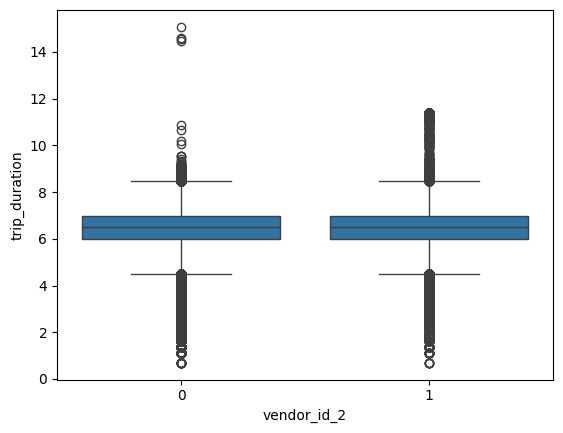

In [1417]:
sns.boxplot(pd.concat((X_train_preprocessed, y_train), axis=1), x='vendor_id_2', y='trip_duration')

In [1418]:
# sns.boxplot(pd.concat((X_train_preprocessed, y_train), axis=1), x='passenger_count', y='trip_duration')

<Axes: xlabel='store_and_fwd_flag_Y', ylabel='trip_duration'>

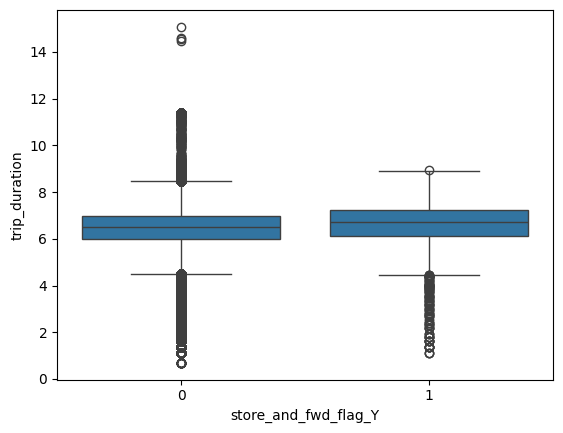

In [1419]:
sns.boxplot(pd.concat((X_train_preprocessed, y_train), axis=1), x='store_and_fwd_flag_Y', y='trip_duration')

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [1420]:
# готово

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [1421]:
# вроде делал уже

Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты (выбросы, или outliers): с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите __обучающую выборку__ от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

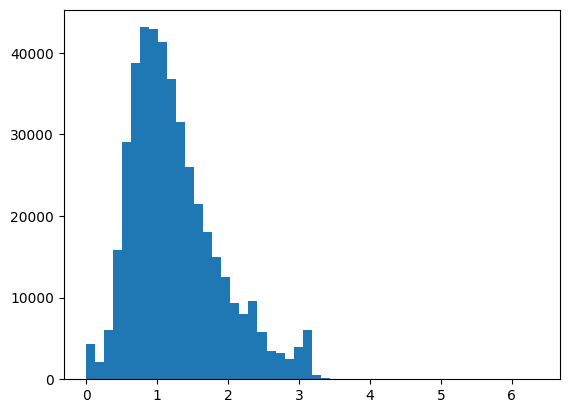

In [1422]:
plt.hist(X_val_preprocessed.log_distance, bins=50)
plt.show()

In [1423]:
y_val = y_val.reset_index(drop=True)

X_train_preprocessed = X_train_preprocessed[(y_train < 8.7) & (y_train > 2)]
y_train = y_train[(y_train < 8.7) & (y_train > 2)]

y_train = y_train[X_train_preprocessed['log_distance'] < 4]
X_train_preprocessed = X_train_preprocessed[X_train_preprocessed['log_distance'] < 4]

In [1424]:
ridge = Ridge().fit(X_train_preprocessed, y_train)
predictions = ridge.predict(X_train_preprocessed)

X_train_preprocessed = X_train_preprocessed[np.abs(y_train-predictions) < 4]
y_train = y_train[np.abs(y_train-predictions) < 4]

In [1425]:
predictions_val = ridge.predict(X_val_preprocessed)
np.sqrt(mean_squared_error(y_val, predictions_val))

np.float64(0.487349768683169)

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Для каждого категориального признака объедините действительно редкие категории в одну, если такие имеются (т.е. если категории действительно редкие).

In [1426]:
X_train_preprocessed.shape

(1018274, 30)

In [1427]:
pickup_dropoff_pairs_train = X_train_preprocessed['pickup_box'].astype(str) + ' ' + X_train_preprocessed['dropoff_box'].astype(str)
pickup_dropoff_pairs_val = X_val_preprocessed['pickup_box'].astype(str) + ' ' + X_val_preprocessed['dropoff_box'].astype(str)

In [2]:
scaler_features = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'distance', 'log_distance']
ohe_features = ['weekday', 'month', 'hour', 'is_jam_period', 'is_free_period', 'start_jfk', 'end_jfk', 'start_lga', 'end_lga', 'start_manhattan', 'end_manhattan', 'pickup_box', 'dropoff_box']


ohe = OneHotEncoder(sparse_output=True, drop='first', handle_unknown='ignore', min_frequency=200)

ohe.fit(X_train_preprocessed[ohe_features])
ohe_new_feature_names = ohe.get_feature_names_out()

X_train_preprocessed = pd.concat([
    X_train_preprocessed,
    pd.DataFrame(ohe.transform(X_train_preprocessed[ohe_features]), index=X_train_preprocessed.index, columns=ohe_new_feature_names).astype(int)
], axis=1).drop(ohe_features, axis=1)
X_val_preprocessed = pd.concat([
    X_val_preprocessed,
    pd.DataFrame(ohe.transform(X_val_preprocessed[ohe_features]), index=X_val_preprocessed.index, columns=ohe_new_feature_names).astype(int)
], axis=1).drop(ohe_features, axis=1)


scaler = StandardScaler()

X_train_preprocessed[scaler_features] = scaler.fit_transform(X_train_preprocessed[scaler_features])
X_val_preprocessed[scaler_features] = scaler.transform(X_val_preprocessed[scaler_features])

NameError: name 'OneHotEncoder' is not defined

In [1429]:
X_train_preprocessed.shape

(1018274, 92)

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [1430]:
# 30, 98

Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [1431]:
from sklearn.linear_model import Ridge, Lasso

ridge = Ridge().fit(X_train_preprocessed, y_train)
lasso = Lasso().fit(X_train_preprocessed, y_train)

prediction_val_ridge = ridge.predict(X_val_preprocessed)
prediction_val_lasso = lasso.predict(X_val_preprocessed)

rmse_ridge = np.sqrt(mean_squared_error(y_val, prediction_val_ridge))
rmse_lasso = np.sqrt(mean_squared_error(y_val, prediction_val_lasso))

print(f"Ridge RMSE: {rmse_ridge:.2f}")
print(f"Lasso RMSE: {rmse_lasso:.2f}")


Ridge RMSE: 0.47
Lasso RMSE: 0.80


Разбейте _обучающую выборку_ на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [1432]:
# Происходит идиотизм потому что тестовой выборки то и не использовалось

X_test_preprocessed = X_val_preprocessed.copy()
y_test = y_val.copy()

X_train_preprocessed, X_val_preprocessed, y_train, y_val = train_test_split(X_train_preprocessed, y_train, train_size=.8)


In [1433]:
alpha_values = np.logspace(-3,3,7,base=10)
best_rmsle = 1e+10
best_alpha = None

zero_weight_count = []

for i, alpha in enumerate(alpha_values):
    ridge = Ridge(alpha).fit(X_train_preprocessed, y_train)
    lasso = Lasso(alpha).fit(X_train_preprocessed, y_train)
    
    prediction_val_ridge = ridge.predict(X_val_preprocessed)
    prediction_val_lasso = lasso.predict(X_val_preprocessed)
    
    rmsle_ridge = np.sqrt(mean_squared_error(y_val, prediction_val_ridge))
    rmsle_lasso = np.sqrt(mean_squared_error(y_val, prediction_val_lasso))

    if rmsle_lasso < best_rmsle:
        best_rmsle = rmsle_lasso
        best_alpha = alpha

    zero_weight_count.append(lasso.coef_[lasso.coef_ == 0].size)
    
    print(f"Iteration {i+1}, alpha = {alpha}:")
    print(f"Ridge RMSLE: {rmsle_ridge:.4f}")
    print(f"Lasso RMSLE: {rmsle_lasso:.4f}\n")

print(f"Best Lasso RMSLE: {best_rmsle:.4f}")
print(f"Best alpha: {best_alpha:.3f}")

Iteration 1, alpha = 0.001:
Ridge RMSLE: 0.4194
Lasso RMSLE: 0.4224

Iteration 2, alpha = 0.01:
Ridge RMSLE: 0.4194
Lasso RMSLE: 0.4401

Iteration 3, alpha = 0.1:
Ridge RMSLE: 0.4194
Lasso RMSLE: 0.4906

Iteration 4, alpha = 1.0:
Ridge RMSLE: 0.4194
Lasso RMSLE: 0.7576

Iteration 5, alpha = 10.0:
Ridge RMSLE: 0.4194
Lasso RMSLE: 0.7583

Iteration 6, alpha = 100.0:
Ridge RMSLE: 0.4195
Lasso RMSLE: 0.7583

Iteration 7, alpha = 1000.0:
Ridge RMSLE: 0.4196
Lasso RMSLE: 0.7583

Best Lasso RMSLE: 0.4224
Best alpha: 0.001


Сохраните наилучшее значение, как бенчмарк на будущее

In [1434]:
# best_rmsle

Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

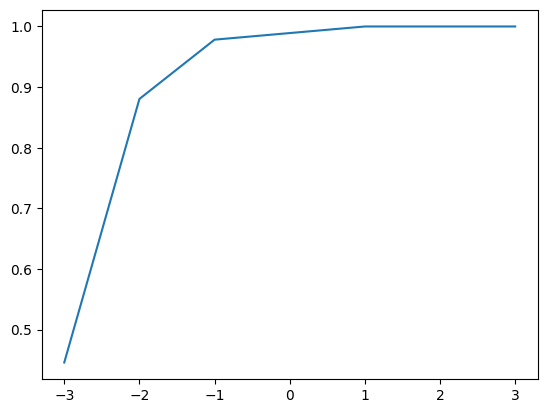

In [1435]:
plt.plot(np.log10(alpha_values), np.array(zero_weight_count)/lasso.coef_.size)

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

In [1436]:
pickup_dropoff_pairs_train[~pickup_dropoff_pairs_train.isin(pickup_dropoff_pairs_train.value_counts()[:100].index)] = '-1'
pickup_dropoff_pairs_val[~pickup_dropoff_pairs_val.isin(pickup_dropoff_pairs_train.value_counts()[:100].index)] = '-1'

X_train_preprocessed['pickup_dropoff_pair'] = pickup_dropoff_pairs_train
X_test_preprocessed['pickup_dropoff_pair'] = pickup_dropoff_pairs_val

ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')

ohe.fit(X_train_preprocessed[['pickup_dropoff_pair']])
ohe_new_feature_names = ohe.get_feature_names_out()

X_train_preprocessed = pd.concat([
    X_train_preprocessed,
    pd.DataFrame(ohe.transform(X_train_preprocessed[['pickup_dropoff_pair']]), index=X_train_preprocessed.index, columns=ohe_new_feature_names).astype(int)
], axis=1).drop('pickup_dropoff_pair', axis=1)
# X_val_preprocessed = pd.concat([
#     X_val_preprocessed,
#     pd.DataFrame(ohe.transform(X_val_preprocessed[['pickup_dropoff_pair']]), index=X_val_preprocessed.index, columns=ohe_new_feature_names).astype(int)
# ], axis=1).drop('pickup_dropoff_pair', axis=1)
X_test_preprocessed = pd.concat([
    X_test_preprocessed,
    pd.DataFrame(ohe.transform(X_test_preprocessed[['pickup_dropoff_pair']]), index=X_test_preprocessed.index, columns=ohe_new_feature_names).astype(int)
], axis=1).drop('pickup_dropoff_pair', axis=1)

Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [1439]:
ridge = Ridge().fit(X_train_preprocessed, y_train)
prediction_test = ridge.predict(X_test_preprocessed)
rmsle = np.sqrt(mean_squared_error(y_test, prediction_test))
print(f"New data RMSLE: {rmsle:.4f}")

New data RMSLE: 0.4657


**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут).

In [1441]:
X_train_preprocessed

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,dayofyear,vendor_id_2,store_and_fwd_flag_Y,anomaly_blizzard_True,anomaly_summer_True,passenger_count_2,...,pickup_dropoff_pair_7 6,pickup_dropoff_pair_7 7,pickup_dropoff_pair_7 8,pickup_dropoff_pair_7 9,pickup_dropoff_pair_8 -1,pickup_dropoff_pair_8 12,pickup_dropoff_pair_8 7,pickup_dropoff_pair_8 8,pickup_dropoff_pair_8 9,pickup_dropoff_pair_9 9
392436,-0.508831,0.013013,-0.243932,-0.024420,14,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
887271,-0.067304,-0.487713,4.504324,-1.312823,174,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
269773,-0.495828,-0.137353,-0.649695,0.141648,69,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
842050,-0.606823,-0.002580,-0.242344,-0.588768,11,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
568204,0.102485,-0.039708,0.200540,0.401611,51,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017687,0.188981,0.364240,0.565608,0.770603,160,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
563320,0.279623,0.915830,0.353396,0.630531,76,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
619268,0.437729,0.931672,-0.051572,0.387680,46,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
184551,0.168629,0.212759,-0.170482,-0.359300,91,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1443]:
angle = 29
sin_angle = np.sin(np.radians(angle))
cos_angle = np.cos(np.radians(angle))

def rotate_coordinates(lat, lon):
    rotated_lat = lon*sin_angle + lat*cos_angle
    rotated_lon = lon*cos_angle - lat*sin_angle
    return (rotated_lat, rotated_lon)

X_train_preprocessed['pickup_latitude_rotated'], X_train_preprocessed['pickup_longitude_rotated'] = rotate_coordinates(
    X_train_preprocessed['pickup_latitude'], X_train_preprocessed['pickup_longitude'])
X_train_preprocessed['dropoff_latitude_rotated'], X_train_preprocessed['dropoff_longitude_rotated'] = rotate_coordinates(
    X_train_preprocessed['dropoff_latitude'], X_train_preprocessed['dropoff_longitude'])

X_test_preprocessed['pickup_latitude_rotated'], X_test_preprocessed['pickup_longitude_rotated'] = rotate_coordinates(
    X_test_preprocessed['pickup_latitude'], X_test_preprocessed['pickup_longitude'])
X_test_preprocessed['dropoff_latitude_rotated'], X_test_preprocessed['dropoff_longitude_rotated'] = rotate_coordinates(
    X_test_preprocessed['dropoff_latitude'], X_test_preprocessed['dropoff_longitude'])


In [1451]:
X_train_preprocessed['log_manhattan_distance'] = np.log1p(
    np.abs(X_train_preprocessed['pickup_latitude_rotated'] - X_train_preprocessed['dropoff_latitude_rotated']) +
    np.abs(X_train_preprocessed['pickup_longitude_rotated'] - X_train_preprocessed['dropoff_longitude_rotated'])
)
X_test_preprocessed['log_manhattan_distance'] = np.log1p(
    np.abs(X_test_preprocessed['pickup_latitude_rotated'] - X_test_preprocessed['dropoff_latitude_rotated']) + 
    np.abs(X_test_preprocessed['pickup_longitude_rotated'] - X_test_preprocessed['dropoff_longitude_rotated'])
)

print(X_train_preprocessed['log_manhattan_distance'].corr(y_train))
print(X_train_preprocessed['log_distance'].corr(y_train))

0.7478999178863793
0.7746550260496714


Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

In [1452]:
ridge = Ridge().fit(X_train_preprocessed, y_train)
prediction_test = ridge.predict(X_test_preprocessed)
rmsle = np.sqrt(mean_squared_error(y_test, prediction_test))
print(f"New data RMSLE: {rmsle:.4f}")

New data RMSLE: 0.4663


**Задание 17 (бонус, 2 балла)**.

Разумеется, погружаться в feature engineering можно ещё очень долго. Ваша задача - придумать какие-то новые признаки, которые сделают модель ещё лучше!! За улучшение функционала ошибки на каждые 0.005 на тестовой выборке относительно `best_rmsle` будет даваться 0.5 бонусных балла. Всего за этот пункт можно получить до 2 бонусных баллов.

При построении признаков старайтесь не допустить утечки целевой переменной (подробнее про это можно почитать в материалах 1-го семинара) — в противном случае хорошего качества на тестовой выборке достичь не получится.

Какие могут быть идеи для вдохновения:

1. Трансформер, который строит разбиение карты по шестигранной решётке с помощью библиотеки [H3](https://github.com/uber/h3-py) и вычисляет признаки на основе такого разбиения, по аналогии с квадратной сеткой  
> Важно: производительность библиотеки существенно зависит от количества шестиугольников на карте (определяется параметром resolution). Подберите такое разрешение, при котором ваш код будет работать за приемлемое время.    

2. Мы пока что никак не использовали историчность и взаимосвязь в данных, хотя информация о том, что было ранее в эти/похожие дни тоже может пригодиться. Попробуйте поискать соседей и/или построить агрегации, например, при помощи groupby, посчитайте какие-либо статистики в пределах какого-то окна (подберите всё это сами, постарайтесь, чтобы это было что-то разумное), и присоедините к основному датафрейму
> Важно: учтите, что разных вариантов агрегаций и статистик существует очень много. Не стесняйтесь выкидывать фичи, которые вам не нравятся (помните про свойство Lasso), используйте эффективные способы хранения данных ([wink](https://www.kaggle.com/code/demche/polars-memory-usage-optimization)-[wink](https://docs.scipy.org/doc/scipy/reference/sparse.html))

3. В конце концов можно использовать альтернативные способы преобразования данных. Например, использовать другой scaler, другую кодировку категориальных фичей, другие гиперпараметры и пр. Но помните, что на данный момент мы ограничены только `Ridge` и `Lasso`

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.